In [1]:
import pandas as pd
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

In [59]:
# get all gages basin characteristics
basin_df = pd.read_csv('../basin_characteristics/gagesII/conterm_basinid.txt', encoding='utf-8')
# filter to HUC02 == 14
basin_df = basin_df[basin_df['HUC02'] == '14']
huc14_stations = basin_df['STAID'].tolist()

In [60]:
# now open the dam data
dam_df = pd.read_csv('../basin_characteristics/gagesII/conterm_hydromod_dams.txt', encoding='utf-8')
dam_df = dam_df[dam_df['STAID'].isin(huc14_stations)]
# drop all NDAMS_2009 > 0
dam_df = dam_df[dam_df['pre1980_NDAMS'] > 1]
# get damn free ids 
dam_stations = dam_df['STAID'].tolist()

In [65]:
# drop values from huc14_stations if in dam_stations
huc14_dam_free = [x for x in huc14_stations if x not in dam_stations]
# add in any missing hcdn 
mask = (~basin_df[['HCDN-2009','HBN36','OLD_HCDN']].isna())
hcdn_stations = basin_df[mask.any(axis=1)].STAID.to_list()
huc14_dam_free = list(set(huc14_dam_free + hcdn_stations))

In [68]:
# get flow record data
flowrec_df = pd.read_csv('../basin_characteristics/gagesII/conterm_flowrec.txt', encoding='utf-8')
flowrec_df = flowrec_df[flowrec_df['STAID'].isin(huc14_dam_free)]
# create a list filled with strings from wy1964 to wy2009
years = list(map(str, list(range(1964, 2010))))
# add wy to each string
years = list(map(lambda x: 'wy' + x, years))
# for each row, get the sum of the years columns
flowrec_df['sum'] = flowrec_df[years].sum(axis=1)
# drop if sum is less than 43
flowrec_df = flowrec_df[flowrec_df['sum'] >= 43]
# drop years not active09
flowrec_df = flowrec_df[flowrec_df['ACTIVE09'] == 'yes']
# get the station ids
flowrec_stations = flowrec_df['STAID'].tolist()

In [91]:
bigger_basins = basin_df[basin_df['STAID'].isin(flowrec_stations)]
# drop basins with areas  < 10 km^2
bigger_basins = bigger_basins[bigger_basins['DRAIN_SQKM'] > 50]
bigger_basin_gages = bigger_basins['STAID'].tolist()


In [95]:
df = pd.read_csv('../basin_characteristics/gagesII/conterm_bas_classif.txt', encoding='utf-8')
df = df[df['STAID'].isin(bigger_basin_gages)]
df = df[df['HYDRO_DISTURB_INDX'] < 13]
# drop these two STAIDs 9299500, 9025000
df = df[~df['STAID'].isin([9299500, 9025000])]
final_basin_gages = df['STAID'].tolist()
final_basins = bigger_basins[bigger_basins['STAID'].isin(final_basin_gages)]
final_basin_gages = ['0'+str(v) for v in final_basin_gages]
final_basins.loc[:,'STAID'] = final_basin_gages


In [50]:
# get basin boundaries
basin_boudary_gdf = gpd.read_file('../basin_characteristics/gagesII/nonref_shapefile/bas_nonref_WestMnts.shp')
basin_boundary_ref_gdf = gpd.read_file('../basin_characteristics/gagesII/ref_shapefile/bas_ref_all.shp')

In [96]:
ucrb_selected_gdf_nonref = basin_boudary_gdf[basin_boudary_gdf['GAGE_ID'].isin(final_basin_gages)]
ucrb_selected_gdf_ref = basin_boundary_ref_gdf[basin_boundary_ref_gdf['GAGE_ID'].isin(final_basin_gages)]
# merge the two dataframes
ucrb_selected_gdf = pd.concat([ucrb_selected_gdf_nonref, ucrb_selected_gdf_ref])
# from final_basins, add these columns to the gdf: STANAME	DRAIN_SQKM	HUC02	LAT_GAGE	LNG_GAGE
ucrb_selected_gdf = ucrb_selected_gdf.merge(final_basins, left_on='GAGE_ID', right_on='STAID')

In [97]:
# transform crs to 32613
ucrb_selected_gdf_32613 = ucrb_selected_gdf.to_crs(epsg=32613)
# convert to 4326
ucrb_selected_gdf_4326 = ucrb_selected_gdf.to_crs(epsg=4326)


In [98]:
ucrb_boundary = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
#  transform crs to 32613
ucrb_boundary_32613 = ucrb_boundary.to_crs(epsg=32613)

<Axes: >

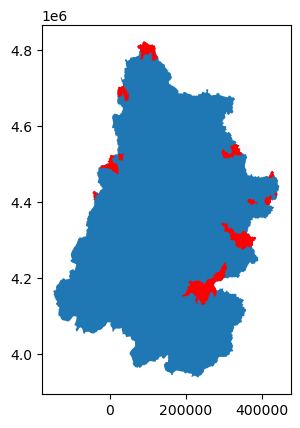

In [99]:

fig, ax = plt.subplots()
ucrb_boundary_32613.plot(ax=ax)
ucrb_selected_gdf_32613.plot(ax=ax, color='red')

In [100]:
# pull in the dem 
ucrb_dem = rxr.open_rasterio('../data/geodata/ucrb_dem_32613_150m.tif')


In [101]:
# iterate through each basin and get the mean elevation, max elevation, and min elevation
for idx, row in ucrb_selected_gdf_32613.iterrows():
    # get the basin boundary
    basin_boundary = row['geometry']
    # get the mean elevation
    tmp = ucrb_dem.rio.clip([basin_boundary], crs=32613)
    # fill negative values with nan
    tmp = tmp.where(tmp > 0, np.nan)
    mean_elevation = tmp.mean().values
    # get the max elevation
    max_elevation = tmp.max().values
    # get the min elevation
    min_elevation = tmp.min().values
    # add the values to the gdf
    ucrb_selected_gdf_32613.loc[idx, 'mean_elevation'] = mean_elevation
    ucrb_selected_gdf_32613.loc[idx, 'max_elevation'] = max_elevation
    ucrb_selected_gdf_32613.loc[idx, 'min_elevation'] = min_elevation

In [102]:
# separate mean elevation into 3 categories
categories = pd.qcut(ucrb_selected_gdf_32613['mean_elevation'],3, labels=['low', 'medium', 'high'])
ucrb_selected_gdf_32613['elevation_category'] = categories.astype(str)
# save the gdf
ucrb_selected_gdf_32613.to_file('../data/geodata/ucrb_selected_basins.geojson', driver='GeoJSON')